
<img src="fga.png" width="1200" height="400">


<h1><center>Aula 4 - Algo Trading
</center></h1>

A presente atividade abordará um conjunto de 3 (três) estratégias didáticas de operações automáticas de compras, baseadas nos indicadores média móvel, MACD e as bandas de Bollinger. As estratégias são apresentadas no formato mais trivial possível, considerando o sentido pedagógico. Em contexto real, aspectos adicionais podem ser naturalmente incorporados, como: i) um processo de otimização regular dos parâmetros, ii) a alocação de stops, iii) a natureza da ordem (mercado/limitada), iv) o período entrada e a v) gestão do risco operacional. Complementarmente, a técnica de Machine Learning denominada de Decision Tree foi aplicada na estratégia de cruzamento de médias com o indicador RSI.


<ul>
    <li> <b>Universidade de Brasília - UnB</b> </li>
    <li> <b>Campus UnB Gama</b> </li>
    <li> <b>Disciplina: Processamento Digital de Sinais Financeiros</b> </li>
    <a href="https://www.linkedin.com/in/marcelino-andrade-b164b369/">
    <li> <b>Prof. Marcelino Monteiro de Andrade Dr.</b> </li>
</ul>



<div id="Tópicos">
    <h2>Tópicos</h2>
</div>


<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol> 
        <li><a href="#Tópico 0">Funções Básicas de Referência</a></li>
        <li><a href="#Tópico 1">Aquisição de Sinais de Preço Bovespa</a></li>
        <li><a href="#Tópico 2">Estratégia Seguidor de Tendência Crossover</a></li>
        <li><a href="#Tópico 3">Estratégia Seguidor de Tendência MACD</a></li>
        <li><a href="#Tópico 4">Estratégia Reversão a Média Bandas de Bollinger</a></li>
        <li><a href="#Tópico 5">Treinamento Seguidor de Tendência Crossover/Decision Tree</a></li>
        <li><a href="#Tópico 6">Avaliação Seguidor de Tendência Crossover/Decision Tree</a></li>
        <li><a href="#Tópico 7">Resultados Consolidados de Todas às Estratégias</a></li>
</ol>
</div>




<p><b>Algumas Bibliotecas Python:</b></p>
<ul>
    <li> numpy (as np) </li>
    <li> matplotlib.pyplot (as plt) </li>
    <li> pandas </li>
    <li> seaborn (as sns) </li>
        <li> mpl_finance (as candlestick_ohlc) </li>
            <li> datetime </li>
                <li> pandas_datareader.data (as pdr)</li>
    <li> pickle</li>
     <li> datetime (as dt)</li>
      <li> signal (from scipy)</li>
</ul>


In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_finance import candlestick_ohlc
import datetime
import pandas_datareader.data as pdr
import pickle
import datetime as dt
from scipy import signal

<div id="Tópico 0">
    <div class="alert alert-block alert-info" style="margin-top: 10px">
        <h><a href="#Tópicos"><h2>1) Funções Básicas de Referência</h2></a></h>   
</div> </div>

In [2]:
def yahoo(symbols,S_Day, S_Month, S_Year, E_Day, E_Month, E_Year):
    yf.pdr_override()       
    stocks_yahoo = pdr.get_data_yahoo(symbols, start=datetime(S_Year, S_Month, S_Day), end=datetime(E_Year, E_Month, E_Day),   as_panel = False,)
    return stocks_yahoo

def ema(data, period=0, column='Close'):
    data['ema' + str(period)] = data[column].ewm(ignore_na=False, min_periods=period, com=period, adjust=True).mean()    
    return data

def macd(data, period_long=26, period_short=12, period_signal=9, column='Close'):
    remove_cols = []
    if not 'ema' + str(period_long) in data.columns:
        data = ema(data, period_long)
        remove_cols.append('ema' + str(period_long))

    if not 'ema' + str(period_short) in data.columns:
        data = ema(data, period_short)
        remove_cols.append('ema' + str(period_short))

    data['macd_val'] = data['ema' + str(period_short)] - data['ema' + str(period_long)]
    data['macd_signal_line'] = data['macd_val'].ewm(ignore_na=False, min_periods=0, com=period_signal, adjust=True).mean()

    data = data.drop(remove_cols, axis=1)
        
    return data

def bollinger_bands(data, trend_periods=20, deviation=2, close_col='Close'):

    data['bol_bands_middle'] = data[close_col].ewm(ignore_na=False, min_periods=0, com=trend_periods, adjust=True).mean()
    for index, row in data.iterrows():

        s = data[close_col].iloc[index - trend_periods: index]
        sums = 0
        middle_band = data.at[index, 'bol_bands_middle']
        for e in s:
            sums += np.square(e - middle_band)

        std = np.sqrt(sums / trend_periods)
   #     d = 2
        upper_band = middle_band + (deviation * std)
        lower_band = middle_band - (deviation * std)

        data.set_value(index, 'bol_bands_upper', upper_band)
        data.set_value(index, 'bol_bands_lower', lower_band)

    return data

def IFR(stock, period=14):
    delta = stock['Close'].diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u = u.ewm(span=period,min_periods=0,adjust=False).mean() #first value is sum of avg gains
    d = d.ewm(span=period,min_periods=0,adjust=False).mean() #first value is sum of avg losses
    stock['IFR']=1 - 1 / (1 + u/d)
    return stock['IFR']

def sumper(per):
    persum=100*(np.exp(np.log1p(per/100).cumsum())-1)
    return persum

def result(values):
    x=list(values)
    lr=np.mean(x)/np.std(x)
    gains=[x for x in values if x > 0]
    losses=[x for x in values if x < 0]
    payoff=100*sumper(np.array(values))[-1]/len(x)
    return len(x),lr, payoff, len(gains)/len(losses), 100*len(gains)/len(x), 100*sumper(np.array(values))[-1]

<div id="Tópico 1">
    <div class="alert alert-block alert-info" style="margin-top: 0px">
        <h><a href="#Tópicos"><h2>2) Aquisição de Sinais de Preço Bovespa</h2></a></h>   
</div> </div> 

<p>Conjunto de procedimentos baseada na biblioteca <b>pandas_datareader.data</b> e <b>Yahoo Finance</b> para aquisição de preços e volumes de ativos finaceiros operados nas principais bolsas de valores mundiais</p>


In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

N_months=115
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 29 09:11:31 2018

@author: Prof Marcelino Andrade
Universidade de Brasilia - UnB
"""

import matplotlib.dates as mdates
import datetime
from pandas import *
import matplotlib.mlab as mlab
import scipy.signal as signal
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
import yfinance as yf
import datetime as dt

sns.set()

Stocks=['ABCB4','RAIL3','WEGE3','RENT3','BIDI4','TRIS3','GSHP3']


Stocks=[Stocks[k]+'.SA' for k in range(len(Stocks))]
#Stocks.append('^BVSP')


today = dt.date.today()
E_Day = today.day; E_Month = today.month; E_Year = today.year
day_before=today - dt.timedelta(days=N_months*365/12)
S_Day = day_before.day; S_Month = day_before.month; S_Year = day_before.year

stocks_all=yahoo(Stocks,S_Day, S_Month, S_Year, E_Day, E_Month, E_Year)

stocks_close=stocks_all['Close'].dropna(axis=0, how='all')
stocks_close=stocks_close.dropna(axis=1, how='any')
stocks_open=stocks_all['Open'].dropna(axis=0, how='all')
stocks_open=stocks_open.dropna(axis=1, how='any')
stocks_high=stocks_all['High'].dropna(axis=0, how='all')
stocks_high=stocks_high.dropna(axis=1, how='any')
stocks_low=stocks_all['Low'].dropna(axis=0, how='all')
stocks_low=stocks_low.dropna(axis=1, how='any')

output = None

symbols=list(stocks_close.columns)

for sy in symbols:

    if output is None:
        df = pd.DataFrame(index=stocks_open.index)
        df['open']=stocks_open[sy]
        df['high']=stocks_high[sy]
        df['low']=stocks_low[sy]
        df['close']=stocks_close[sy]

        output = df          

    else:
        df = pd.DataFrame(index=stocks_open.index)
        df['open']=stocks_open[sy]
        df['high']=stocks_high[sy]
        df['low']=stocks_low[sy]
        df['close']=stocks_close[sy]

        
        output=pd.concat([output,df],axis=1) 

#output.reset_index(drop=True, inplace=True)
col1=[]
for sy in symbols:
    forall=[]
    for i in range(4):
        forall.append(sy)
    col1=col1+forall
col2=list(output.columns)

col = pd.MultiIndex.from_arrays([col1,col2])
data = pd.DataFrame(output.values, columns=col)

    
pickle_out = open("data.pickle","wb")
pickle.dump(data, pickle_out)
pickle_out.close() 

pickle_out = open("df.pickle","wb")
pickle.dump(df, pickle_out)
pickle_out.close() 

data[symbols].tail()


[*********************100%***********************]  7 of 7 downloaded


WEGE3.SA                     
         open   high    low  close
2365    22.50  22.71  22.35  22.63
2366    22.82  23.14  22.75  22.78
2367    23.00  23.09  22.62  22.84
2368    22.92  23.05  22.58  22.58
2369    22.70  23.32  22.60  22.93

<div id="Tópico 2">
    <div class="alert alert-block alert-info" style="margin-top: 0px">
        <h><a href="#Tópicos"><h2>3) Estratégia Seguidor de Tendência Crossover</h2></a></h>   
</div> </div>

<p>O Crossover corresponde a uma das mais simples estratégias de Trade automático, podendo ser baseadas no cruzamento do preço com uma média, no cruzamento de duas ou mais médias móveis. A seguir será desenvolvido uma solução, somente comprada, e baseada no cruzamento de duas médias. Assim, considerado uma média rápida $FMA$ e uma lenta $SMA$, o sinal de compra deve ocorrer quando</p>&emsp;
    
<ul>
    
  <li>$FMA[n-1] < SMA[n-1]$ e $FMA[n] > SMA[n]$ </li>

<p>E o sinal de venda<p>

  <li> $FMA[n-1] > SMA[n-1]$ e $FMA[n] < SMA[n]$ </li>

</ul>
<p>Ou ainda, a compra pode ocorrer quando a $FMA[n]$ apresentar um distância $k\sigma[n]$ acima da $SMA[n]$, após o cruzamento. E a venda em situação 
análoga e antagônica.</p>

<p>O valor de $k\sigma[n]$ e dos periodos das médias $FMA$ e $SMA$ podem ser extraídos de processo de otimização, considerando janelas temporais significativas e aplicados
em periodos out-of-sample (OOS) e in-sample (IS). </p>

  

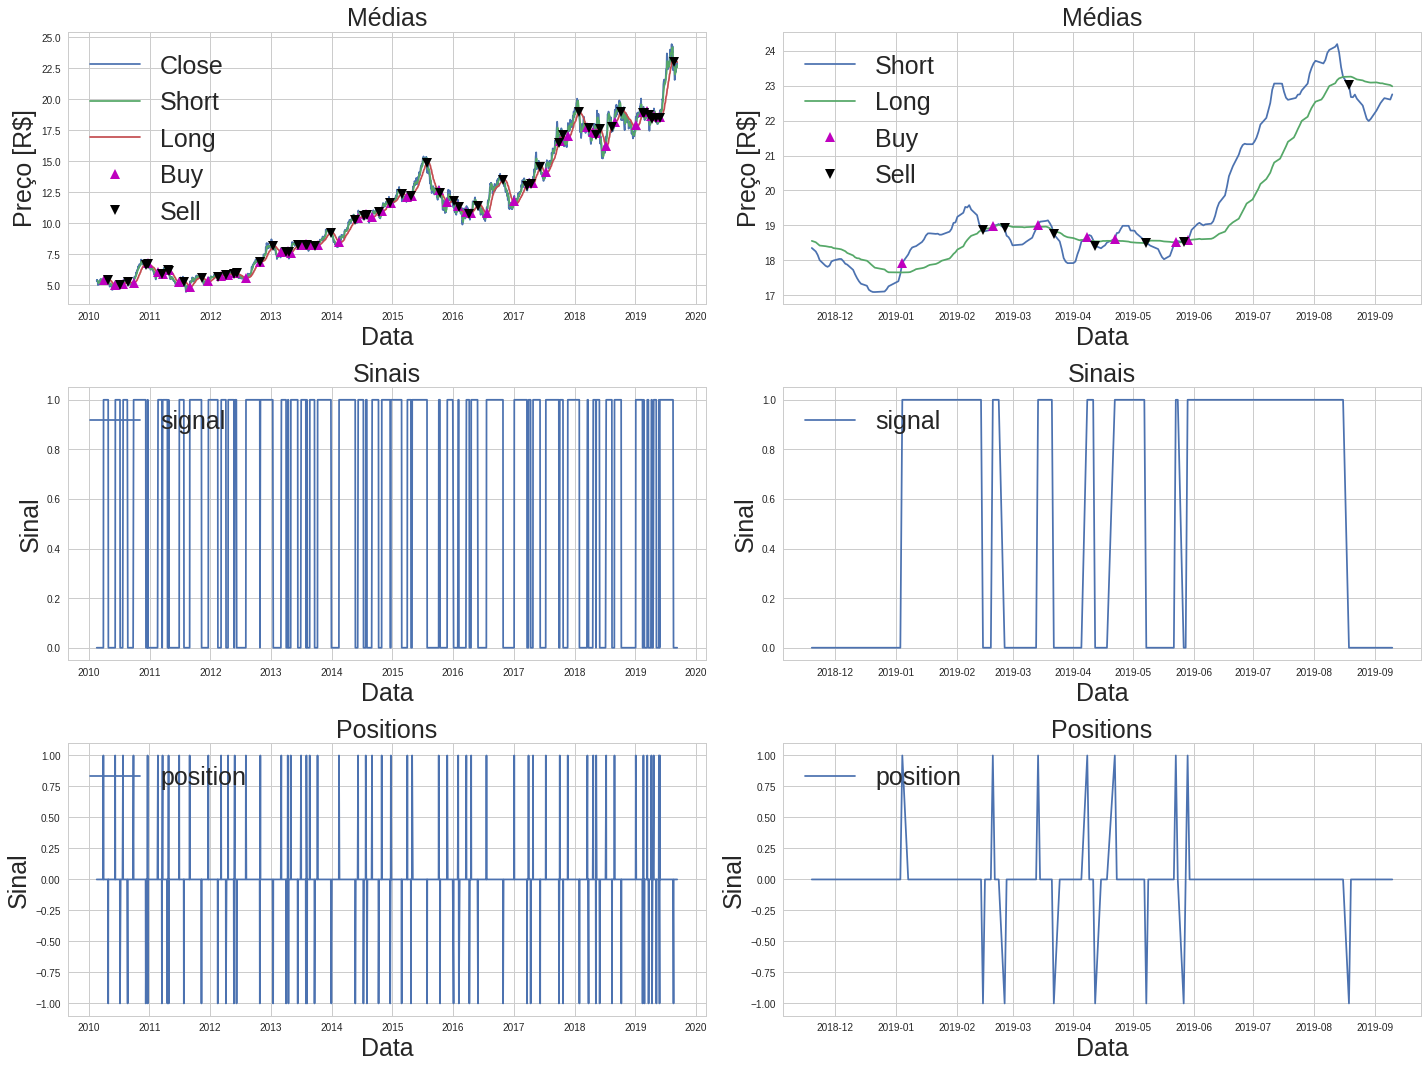

In [4]:
trades = pd.DataFrame(index=df.index)
trades['Close']=data['WEGE3.SA'].close.values

short=5
long=30

trades['short'] = trades['Close'].rolling(window=short).mean()
trades['long'] = trades['Close'].rolling(window=long).mean()

# Sinal de Entrada
trades['signal']=0
trades['signal'][short:] = np.where(trades['short'][short:] > trades['long'][short:], 1.0, 0.0)   

# Posição dos trades
trades['positions'] = trades['signal'].diff()

fig = plt.subplots(figsize=(20,15))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(321)
ax1.plot(trades['Close'], label='Close')
ax1.plot(trades['short'], label='Short')
ax1.plot(trades['long'],label='Long')

ax1.plot(trades.loc[trades.positions == 1.0].index, 
         trades.short[trades.positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax1.plot(trades.loc[trades.positions == -1.0].index, 
         trades.short[trades.positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 

ax1.set_ylabel("Preço [R$]",fontsize=25)
ax1.set_xlabel("Data",fontsize=25)
ax1.set_title("Médias",fontsize=25)
ax1.legend(loc='upper left',fontsize=25)

ax2 = plt.subplot(322)
#ax2.plot(trades['Close'][-200:], label='Close')
ax2.plot(trades['short'][-200:], label='Short')
ax2.plot(trades['long'][-200:],label='Long')
ax2.set_ylabel("Preço [R$]",fontsize=25)
ax2.set_xlabel("Data",fontsize=25)
ax2.set_title("Médias",fontsize=25)
ax2.plot(trades[-200:].loc[trades[-200:].positions == 1.0].index, 
         trades[-200:].short[trades[-200:].positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax2.plot(trades[-200:].loc[trades[-200:].positions == -1.0].index, 
         trades[-200:].short[trades[-200:].positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 
ax2.legend(loc='upper left',fontsize=25)

ax3 = plt.subplot(323)
ax3.plot(trades['signal'], label='signal')
ax3.set_ylabel("Sinal",fontsize=25)
ax3.set_xlabel("Data",fontsize=25)
ax3.set_title("Sinais",fontsize=25)
ax3.legend(loc='upper left',fontsize=25)

ax4 = plt.subplot(324)
ax4.plot(trades['signal'][-200:], label='signal')
ax4.set_ylabel("Sinal",fontsize=25)
ax4.set_xlabel("Data",fontsize=25)
ax4.set_title("Sinais",fontsize=25)
ax4.legend(loc='upper left',fontsize=25)

ax5 = plt.subplot(325)
ax5.plot(trades['positions'], label='position')
ax5.set_ylabel("Sinal",fontsize=25)
ax5.set_xlabel("Data",fontsize=25)
ax5.set_title("Positions",fontsize=25)
ax5.legend(loc='upper left',fontsize=25)

ax6 = plt.subplot(326)
ax6.plot(trades['positions'][-200:], label='position')
ax6.set_ylabel("Sinal",fontsize=25)
ax6.set_xlabel("Data",fontsize=25)
ax6.set_title("Positions",fontsize=25)
ax6.legend(loc='upper left',fontsize=25)
plt.tight_layout() 

<div>
    <div class="alert alert-block alert-info" style="margin-top: 5px">
        <h>3.1) Retornos da Estratégia Seguidor de Tendência Crossover</h>
</div> </div>


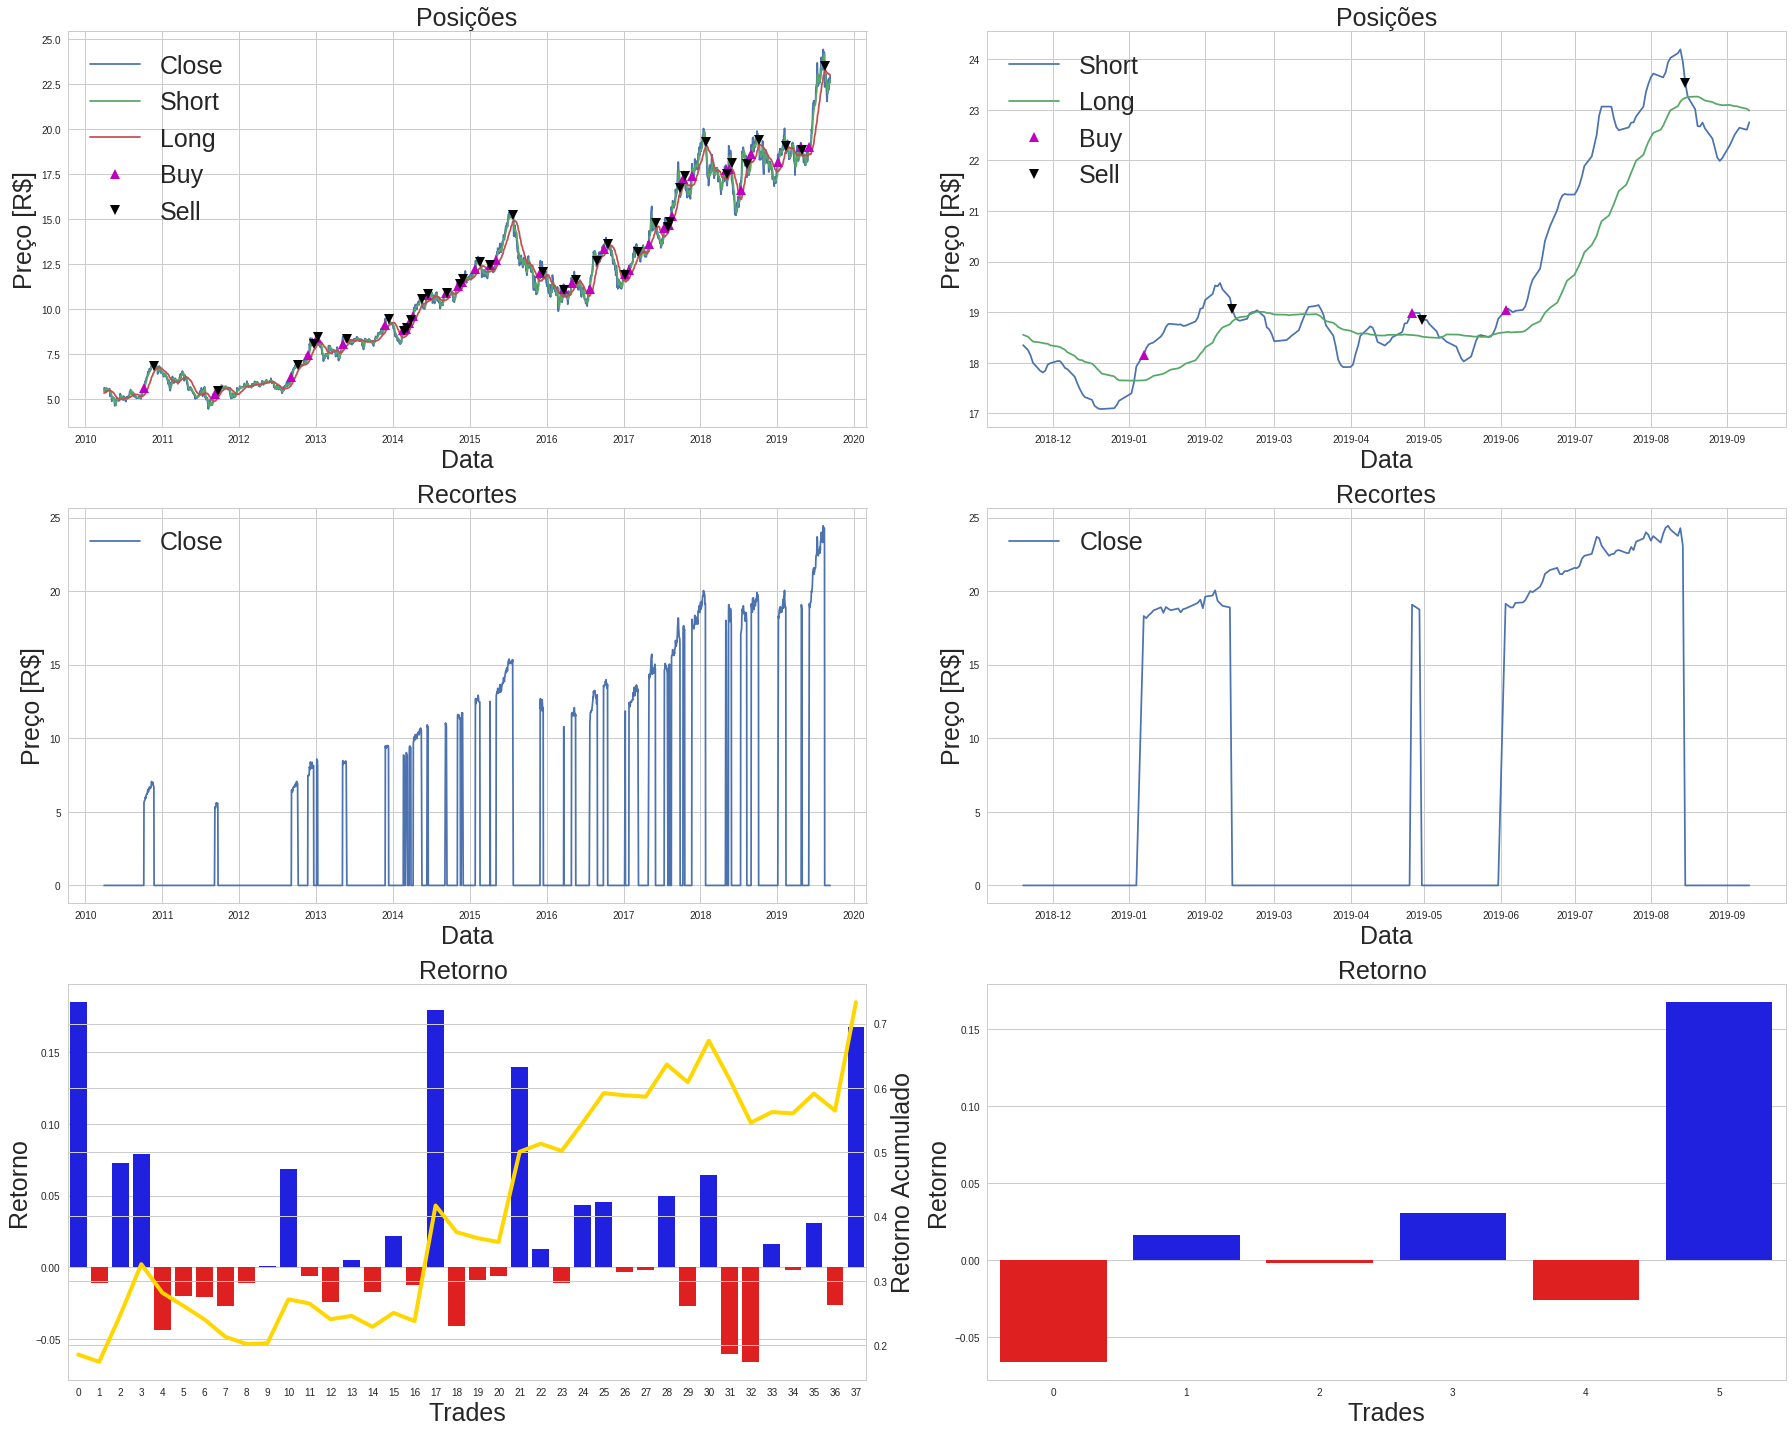

In [26]:
trades['Close_recorte']=trades['Close']*trades['signal']
%matplotlib inline   
fig = plt.subplots(figsize=(25,20))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(321)
ax1.plot(trades['Close'], label='Close')
ax1.plot(trades['short'], label='Short')
ax1.plot(trades['long'],label='Long')

ax1.plot(trades.loc[trades.positions == 1.0].index, 
         trades.short[trades.positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax1.plot(trades.loc[trades.positions == -1.0].index, 
         trades.short[trades.positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 

ax1.set_ylabel("Preço [R$]",fontsize=25)
ax1.set_xlabel("Data",fontsize=25)
ax1.set_title("Posições",fontsize=25)
ax1.legend(loc='upper left',fontsize=25)

ax2 = plt.subplot(322)
#ax2.plot(trades['Close'][-200:], label='Close')
ax2.plot(trades['short'][-200:], label='Short')
ax2.plot(trades['long'][-200:],label='Long')
ax2.set_ylabel("Preço [R$]",fontsize=25)
ax2.set_xlabel("Data",fontsize=25)
ax2.set_title("Posições",fontsize=25)
ax2.plot(trades[-200:].loc[trades[-200:].positions == 1.0].index, 
         trades[-200:].short[trades[-200:].positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax2.plot(trades[-200:].loc[trades[-200:].positions == -1.0].index, 
         trades[-200:].short[trades[-200:].positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 
ax2.legend(loc='upper left',fontsize=25)

ax3 = plt.subplot(323)
ax3.plot(trades['Close_recorte'], label='Close')
ax3.set_ylabel("Preço [R$]",fontsize=25)
ax3.set_xlabel("Data",fontsize=25)
ax3.set_title("Recortes",fontsize=25)
ax3.legend(loc='upper left',fontsize=25)

ax4 = plt.subplot(324)
ax4.plot(trades['Close_recorte'][-200:], label='Close')
ax4.set_ylabel("Preço [R$]",fontsize=25)
ax4.set_xlabel("Data",fontsize=25)
ax4.set_title("Recortes",fontsize=25)
ax4.legend(loc='upper left',fontsize=25)

ax5 = plt.subplot(325)
pos_buy=np.where(trades['positions']==1)
pos_sell=trades['positions']==-1
days_buy=trades['Close'][trades['positions']==1].index
days_sell=trades['Close'][trades['positions']==-1].index
distance=days_sell-days_buy
buy_trade=[]
for i in range(len(days_buy)):
    values_2=trades['Close'][trades['Close'].index==(days_buy[i]+distance[i])].values[0]
    values_1=trades['Close'][trades['Close'].index==days_buy[i]].values[0]
    buy_trade.append((values_2-values_1)/values_1)

values = np.array(buy_trade)
values1=buy_trade

idx = np.array(list(range(len(buy_trade)))) 
clrs = ['red' if (x < 0) else 'blue' for x in values]
sns.barplot(x=idx, y=values, palette=clrs) 

plt.ylabel('Retorno',fontsize=25)
plt.xlabel('Trades',fontsize=25)

ax52 = ax5.twinx()

ax52.plot(sumper(values),'gold',linewidth=4)

plt.ylabel('Retorno Acumulado',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Retorno ',fontsize=25)


ax6 = plt.subplot(326)
pos_buy=np.where(trades['positions']==1)
pos_sell=trades['positions']==-1
days_buy=trades['Close'][trades['positions']==1].index
days_sell=trades['Close'][trades['positions']==-1].index
distance=days_sell-days_buy
buy_trade=[]
for i in range(len(days_buy)):
    values_2=trades['Close'][trades['Close'].index==(days_buy[i]+distance[i])].values[0]
    values_1=trades['Close'][trades['Close'].index==days_buy[i]].values[0]
    buy_trade.append((values_2-values_1)/values_1)
values = np.array(buy_trade[-6:])   
idx = np.array(list(range(len(values)))) 
clrs = ['red' if (x < 0) else 'blue' for x in values]
sns.barplot(x=idx, y=values, palette=clrs) 


plt.ylabel('Retorno',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Retorno ',fontsize=25)
plt.tight_layout() 


<div id="Tópico 3">
    <div class="alert alert-block alert-info" style="margin-top: 1px">
        <h><a href="#Tópicos"><h2>4) Estratégia Seguidor de Tendência MACD</h2></a></h>   
</div> </div>

<p>Desenvolvido por <b>Gerald Appel</b> no final dos anos 70, o MACD (Moving Average Convergence / Divergence Oscillator) transforma dois seguidores de tendência, médias móveis, em um oscilador de momento. A seguir será apresentada uma estratégia, somente comprada, e baseada no cruzamento dos sinais do $MACD$.</p>

<p>O <b>Sinal de Compra</b><p>

  <li>$MACD[n]>Sinal[n]$ e $MACD[n-1]>Sinal[n-1]$</li>

<p>O <b>Sinal de Venda</b><p>

  <li>$MACD[n] < Sinal[n]$ e $MACD[n-1] < Sinal[n-1]$</li>

<p>Ou ainda, para ficar fiel ao setup apresentado por <b> Gerald Appel</b> a compra pode ocorrer quando o $MACD[n]$ e o $Sinal[n]$ apresentarem valores negativos.</p>


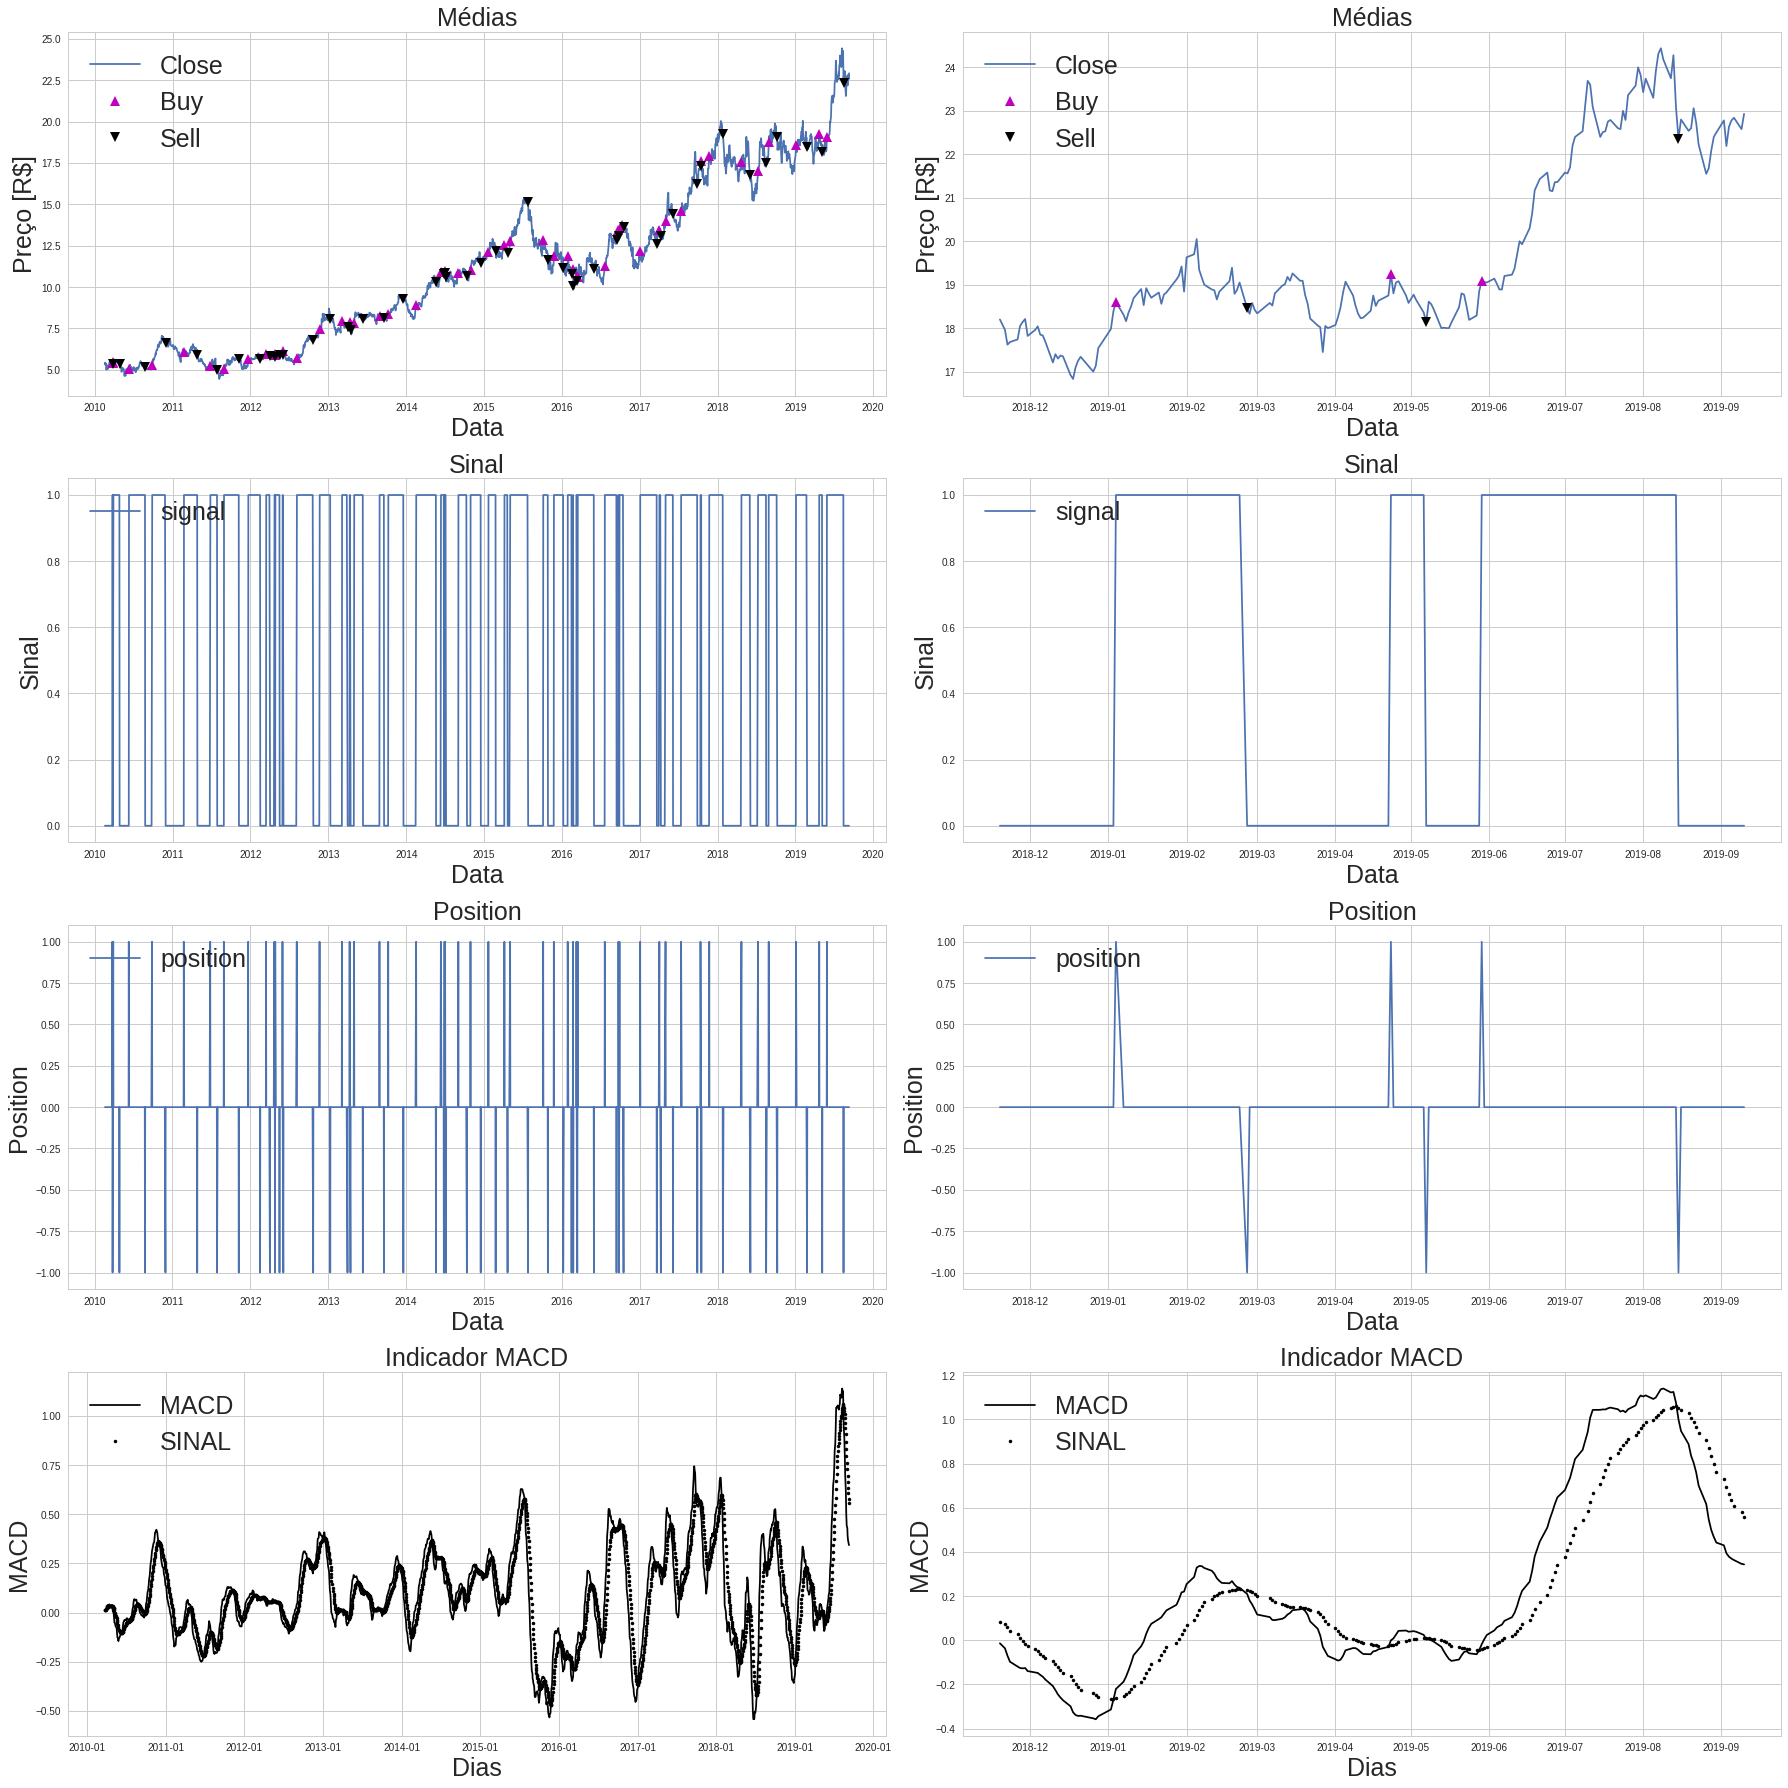

In [6]:
trades = pd.DataFrame(index=df.index)
trades['Close']=data['WEGE3.SA'].close.values
macd(trades)
# Sinal de Entrada
trades['signal']=0
trades['signal'] = np.where(trades['macd_val'] > trades['macd_signal_line'], 1.0, 0.0)   

# Posição dos trades
trades['positions'] = trades['signal'].diff()

fig = plt.subplots(figsize=(25,25))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(421)
ax1.plot(trades['Close'], label='Close')

ax1.plot(trades.loc[trades.positions == 1.0].index, 
         trades.Close[trades.positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax1.plot(trades.loc[trades.positions == -1.0].index, 
         trades.Close[trades.positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 

ax1.set_ylabel("Preço [R$]",fontsize=25)
ax1.set_xlabel("Data",fontsize=25)
ax1.set_title("Médias",fontsize=25)
ax1.legend(loc='upper left',fontsize=25)

ax2 = plt.subplot(422)
ax2.plot(trades['Close'][-200:], label='Close')

ax2.set_ylabel("Preço [R$]",fontsize=25)
ax2.set_xlabel("Data",fontsize=25)
ax2.set_title("Médias",fontsize=25)

ax2.plot(trades[-200:].loc[trades[-200:].positions == 1.0].index, 
         trades[-200:].Close[trades[-200:].positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax2.plot(trades[-200:].loc[trades[-200:].positions == -1.0].index, 
         trades[-200:].Close[trades[-200:].positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 

ax2.legend(loc='upper left',fontsize=25)

ax3 = plt.subplot(423)
ax3.plot(trades['signal'], label='signal')
ax3.set_ylabel("Sinal",fontsize=25)
ax3.set_xlabel("Data",fontsize=25)
ax3.set_title("Sinal",fontsize=25)
ax3.legend(loc='upper left',fontsize=25)

ax4 = plt.subplot(424)
ax4.plot(trades['signal'][-200:], label='signal')
ax4.set_ylabel("Sinal",fontsize=25)
ax4.set_xlabel("Data",fontsize=25)
ax4.set_title("Sinal",fontsize=25)
ax4.legend(loc='upper left',fontsize=25)

ax5 = plt.subplot(425)
ax5.plot(trades['positions'], label='position')
ax5.set_ylabel("Position",fontsize=25)
ax5.set_xlabel("Data",fontsize=25)
ax5.set_title("Position",fontsize=25)
ax5.legend(loc='upper left',fontsize=25)

ax6 = plt.subplot(426)
ax6.plot(trades['positions'][-200:], label='position')
ax6.set_ylabel("Position",fontsize=25)
ax6.set_xlabel("Data",fontsize=25)
ax6.set_title("Position",fontsize=25)
ax6.legend(loc='upper left',fontsize=25)

ax7 = plt.subplot(427)
ax7.plot(trades['macd_val'], 'k', label = 'MACD')
ax7.plot(trades['macd_signal_line'], 'k.', label = 'SINAL')
ax7.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax7.legend(loc='upper left',fontsize=25)

ax7.set_xlabel("Dias",fontsize=25)
ax7.set_ylabel('MACD',fontsize=25)
ax7.set_title('Indicador MACD',fontsize=25) 

ax8 = plt.subplot(428)
ax8.plot(trades['macd_val'][-200:], 'k', label = 'MACD')
ax8.plot(trades['macd_signal_line'][-200:], 'k.', label = 'SINAL')
ax8.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax8.legend(loc='upper left',fontsize=25)

ax8.set_xlabel("Dias",fontsize=25)
ax8.set_ylabel('MACD',fontsize=25)
ax8.set_title('Indicador MACD',fontsize=25) 
plt.tight_layout() 


<div>
    <div class="alert alert-block alert-info" style="margin-top: 5px">
        <h>4.1) Retornos Estratégia Seguidor de Tendência MACD¶</h>
</div> </div>

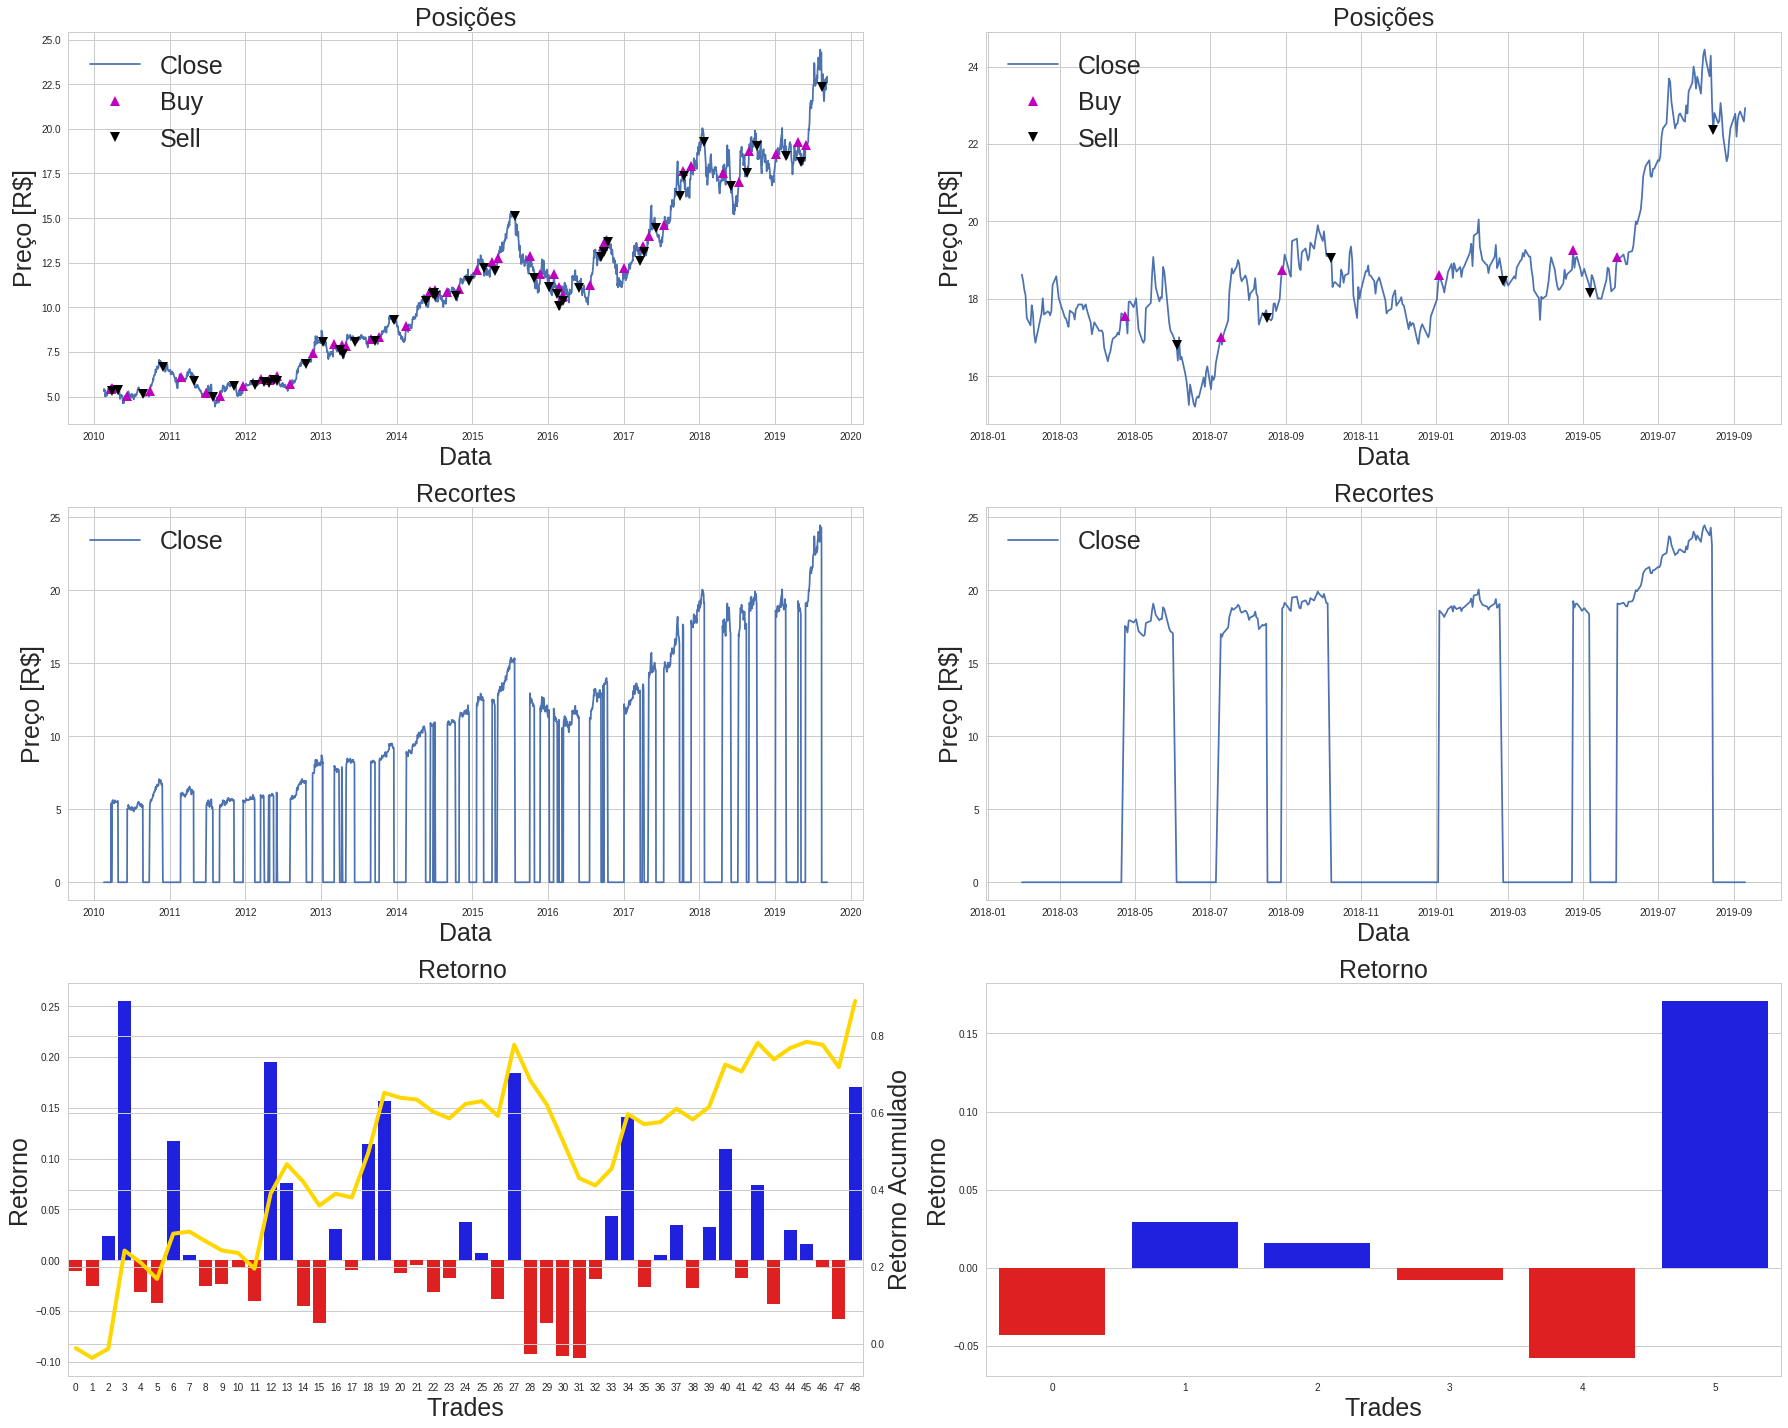

In [7]:
trades['Close_recorte']=trades['Close']*trades['signal']

fig = plt.subplots(figsize=(25,20))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(321)
ax1.plot(trades['Close'], label='Close')
#ax1.plot(trades['short'], label='Short')
#ax1.plot(trades['long'],label='Long')

ax1.plot(trades.loc[trades.positions == 1.0].index, 
         trades.Close[trades.positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax1.plot(trades.loc[trades.positions == -1.0].index, 
         trades.Close[trades.positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 

ax1.set_ylabel("Preço [R$]",fontsize=25)
ax1.set_xlabel("Data",fontsize=25)
ax1.set_title("Posições",fontsize=25)
ax1.legend(loc='upper left',fontsize=25)

ax2 = plt.subplot(322)
ax2.plot(trades['Close'][-400:], label='Close')
#ax2.plot(trades['short'][-200:], label='Short')
#ax2.plot(trades['long'][-200:],label='Long')
ax2.set_ylabel("Preço [R$]",fontsize=25)
ax2.set_xlabel("Data",fontsize=25)
ax2.set_title("Posições",fontsize=25)
ax2.plot(trades[-400:].loc[trades[-400:].positions == 1.0].index, 
         trades[-400:].Close[trades[-400:].positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax2.plot(trades[-400:].loc[trades[-400:].positions == -1.0].index, 
         trades[-400:].Close[trades[-400:].positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 
ax2.legend(loc='upper left',fontsize=25)

ax3 = plt.subplot(323)
ax3.plot(trades['Close_recorte'], label='Close')
ax3.set_ylabel("Preço [R$]",fontsize=25)
ax3.set_xlabel("Data",fontsize=25)
ax3.set_title("Recortes",fontsize=25)
ax3.legend(loc='upper left',fontsize=25)

ax4 = plt.subplot(324)
ax4.plot(trades['Close_recorte'][-400:], label='Close')
ax4.set_ylabel("Preço [R$]",fontsize=25)
ax4.set_xlabel("Data",fontsize=25)
ax4.set_title("Recortes",fontsize=25)
ax4.legend(loc='upper left',fontsize=25)

ax5 = plt.subplot(325)
pos_buy=np.where(trades['positions']==1)
pos_sell=trades['positions']==-1
days_buy=trades['Close'][trades['positions']==1].index
days_sell=trades['Close'][trades['positions']==-1].index
distance=days_sell-days_buy
buy_trade=[]
for i in range(len(days_buy)):
    values_2=trades['Close'][trades['Close'].index==(days_buy[i]+distance[i])].values[0]
    values_1=trades['Close'][trades['Close'].index==days_buy[i]].values[0]
    buy_trade.append((values_2-values_1)/values_1)
values = np.array(buy_trade)   
values2=buy_trade

idx = np.array(list(range(len(buy_trade)))) 
clrs = ['red' if (x < 0) else 'blue' for x in values]
sns.barplot(x=idx, y=values, palette=clrs) 


ax5.set_ylabel('Retorno',fontsize=25)
ax5.set_xlabel('Trades',fontsize=25)
#ax5.set_title('Retorno',fontsize=25)
ax52 = ax5.twinx()
ax52.plot(sumper(values),'gold',linewidth=4)

plt.ylabel('Retorno Acumulado',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Retorno ',fontsize=25)

ax6 = plt.subplot(326)
pos_buy=trades['positions']==1
pos_sell=trades['positions']==-1
days_buy=trades['Close'][trades['positions']==1].index
days_sell=trades['Close'][trades['positions']==-1].index
distance=days_sell-days_buy
buy_trade=[]
for i in range(len(days_buy)):
    values_2=trades['Close'][trades['Close'].index==(days_buy[i]+distance[i])].values[0]
    values_1=trades['Close'][trades['Close'].index==days_buy[i]].values[0]
    buy_trade.append((values_2-values_1)/values_1)
    
values = np.array(buy_trade[-6:])   
idx = np.array(list(range(len(values)))) 
clrs = ['red' if (x < 0) else 'blue' for x in values]
sns.barplot(x=idx, y=values, palette=clrs) 


plt.ylabel('Retorno',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Retorno',fontsize=25)
plt.tight_layout() 


<div id="Tópico 4">
    <div class="alert alert-block alert-info" style="margin-top: 0px">
        <h><a href="#Tópicos"><h2>5) Estratégia Reversão a Média Bandas de Bollinger</h2></a></h>   
</div> </div>

<p>A estratégia em bandas de bollinger apresentada obedece a conjuntura de retorno à média central da banda. A seguir será desenvolvido uma estratégia, somente comprada, e baseada nas bandas de Bollinger. Assim, considerado banda inferior $Bandlower$, a banda média $Bandmiddle$ e o preço de fechamento $Close$,</p>

<p>o <b>sinal de compra</b> deve ocorrer quando</p>&emsp;

<li>$Bandlower[n-1] < Close[n-1]$ e $Bandlower[n] > Close[n]$</li>&emsp;

<p>e o <b>sinal de venda</b><p>&emsp;

<li>$Bandmiddle[n-1] > Close[n-1]$ e $Bandmiddle[n] < Close[n]$</li>

 

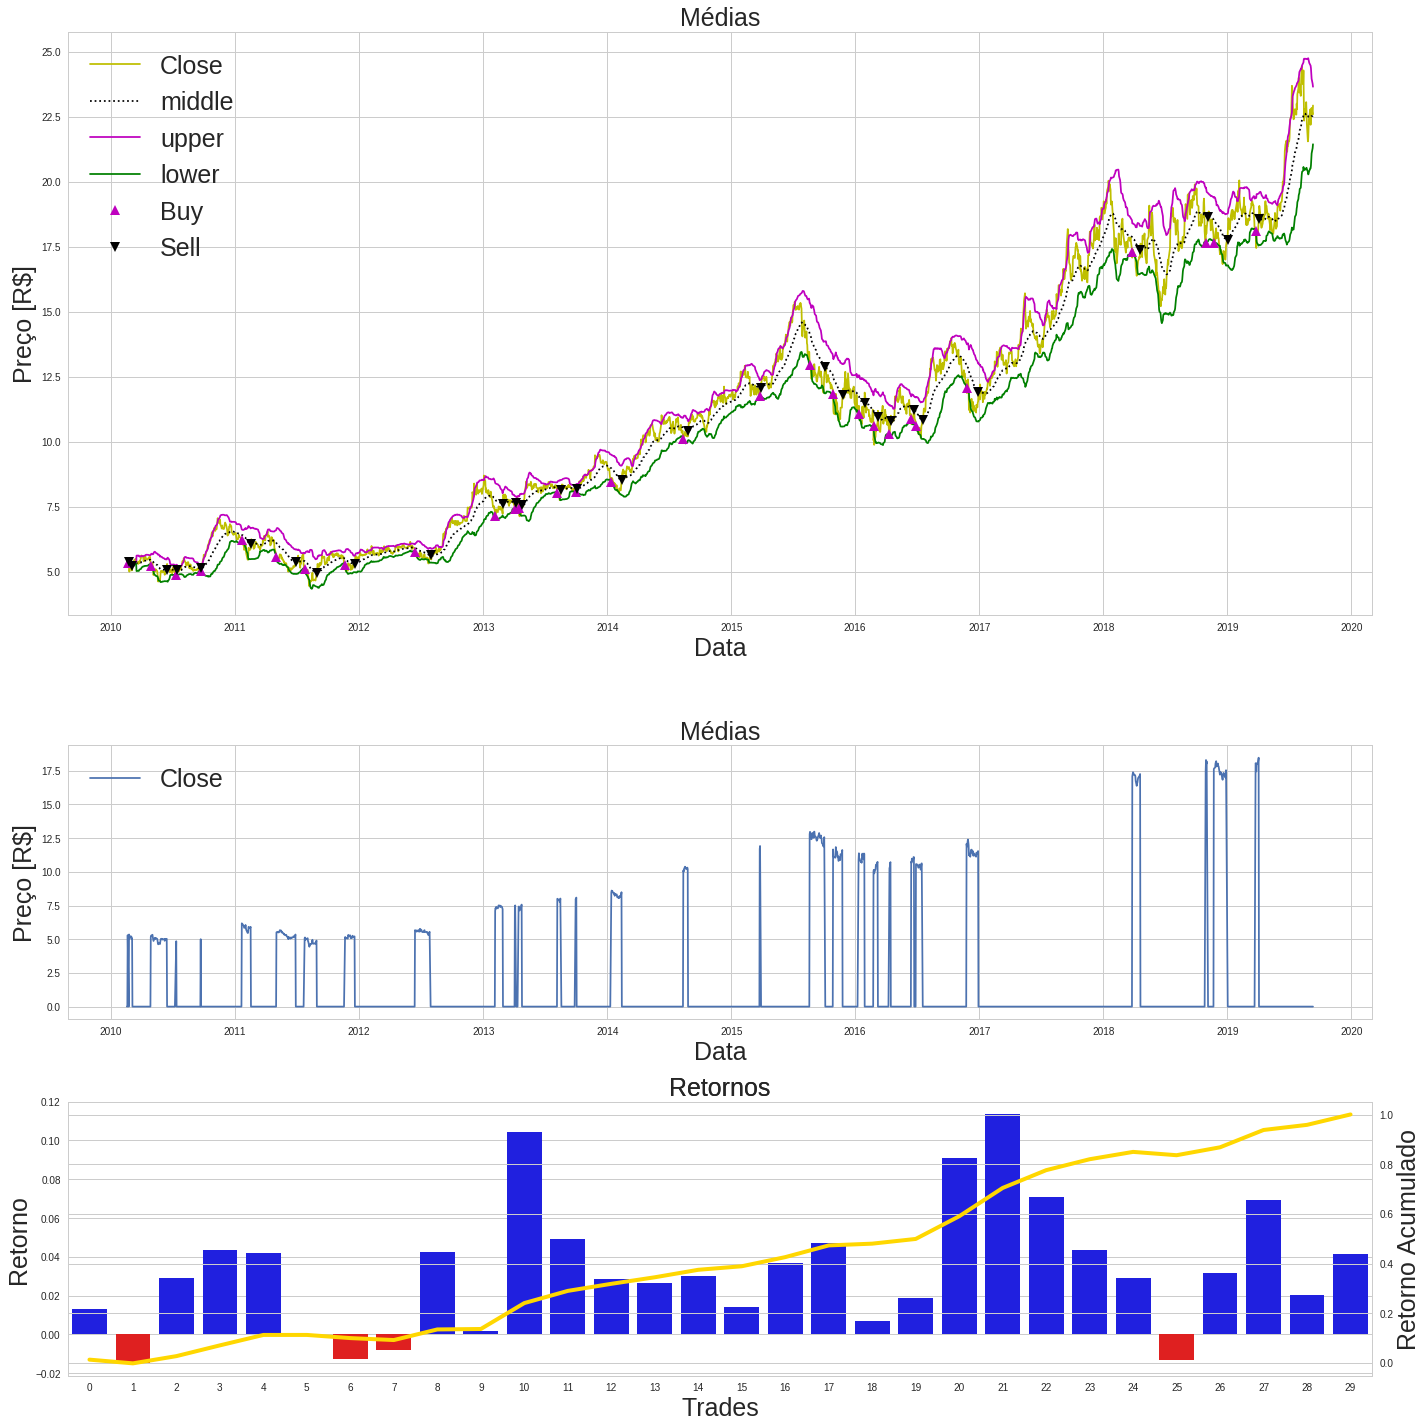

In [8]:
trades = pd.DataFrame(index=df.index)
trades['Close']=data['WEGE3.SA'].close.values
trades.reset_index(inplace=True)
bollinger_bands(trades)

trades=trades.set_index('Date')
# Sinal de Entrada
trades['signal']=0
signal=np.zeros(len(trades['signal']))
buy=0
for day in range(1,len(trades)):
    cond1_buy=trades['Close'].iloc[day-1] > trades['bol_bands_lower'].iloc[day-1]
    cond2_buy=trades['Close'].iloc[day] < trades['bol_bands_lower'].iloc[day]  
    cond1_sell=trades['Close'].iloc[day-1] < trades['bol_bands_middle'].iloc[day-1]
    cond2_sell=trades['Close'].iloc[day] > trades['bol_bands_middle'].iloc[day]   

    if cond1_buy & cond2_buy:
        buy = 1
    if (buy == True) & cond1_sell & cond2_sell:
        buy = 0
    signal[day]=buy
trades['signal']=signal
#condition2=trades['Close'] < trades['bol_bands_lower']

#trades['signal'] = np.where(, 1.0, 0.0)   

#trades
# Posição dos trades
trades['positions'] = trades['signal'].diff()

fig = plt.subplots(figsize=(20,20))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(211)
ax1.plot( trades.Close, 'y', label = 'Close')
ax1.plot( trades.bol_bands_middle, 'k:', label = 'middle')
ax1.plot( trades.bol_bands_upper, 'm', label = 'upper')
ax1.plot( trades.bol_bands_lower, 'g', label = 'lower')

ax1.plot(trades.loc[trades.positions == 1.0].index, 
         trades.bol_bands_lower[trades.positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax1.plot(trades.loc[trades.positions == -1.0].index, 
         trades.bol_bands_middle[trades.positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 

ax1.set_ylabel("Preço [R$]",fontsize=25)
ax1.set_xlabel("Data",fontsize=25)
ax1.set_title("Médias",fontsize=25)
ax1.legend(loc='upper left',fontsize=25)



trades['Close_recorte']=trades['Close']*trades['signal']

#trades['Close_recorte'][trades['Close_recorte']==0]=16

ax3 = plt.subplot(413)
ax3.plot(trades['Close_recorte'], label='Close')
ax3.set_ylabel("Preço [R$]",fontsize=25)
ax3.set_xlabel("Data",fontsize=25)
ax3.set_title("Médias",fontsize=25)
ax3.legend(loc='upper left',fontsize=25)



ax5 = plt.subplot(414)
pos_buy=np.where(trades['positions']==1)
pos_sell=trades['positions']==-1
days_buy=trades['Close'][trades['positions']==1].index
days_sell=trades['Close'][trades['positions']==-1].index
distance=days_sell-days_buy
buy_trade=[]
for i in range(len(days_buy)):
    values_2=trades['Close'][trades['Close'].index==(days_buy[i]+distance[i])].values[0]
    values_1=trades['Close'][trades['Close'].index==days_buy[i]].values[0]
    buy_trade.append((values_2-values_1)/values_1)
values = np.array(buy_trade)   
values3=buy_trade
plt.ylabel('Retorno',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Retornos',fontsize=25)


idx = np.array(list(range(len(buy_trade)))) 
clrs = ['red' if (x < 0) else 'blue' for x in values]
sns.barplot(x=idx, y=values, palette=clrs) 
ax52 = ax5.twinx()
ax52.plot(sumper(values),'gold',linewidth=4)

plt.ylabel('Retorno Acumulado',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Retornos',fontsize=25)

plt.tight_layout() 



<div id="Tópico 5">
    <div class="alert alert-block alert-info" style="margin-top: 0px">
        <h><a href="#Tópicos"><h2>6) Treinamento Seguidor de Tendência Crossover/Decision Tree</h2></a></h>   
</div> </div>

<p>A técnica de Aprendizado de Máquina denominada de Árvores de decisão representam modelos estatísticos supervisionado orientados para a classificação e também predição. A técnica utilizam a estratégia de dividir para conquistar baseado na minimização da entropia, quando o algoritmo ID3 é aplicado.</p>&emsp;
    

<li>Uma árvore corresponde a um conjunto de regras objetivas de decisão</li>&emsp;
    

<li>Cada regra possuí partida na raiz da árvore e segue para baixo no sendido das folhas</li>&emsp;
    

<li>Os nós de decisão possuem testes com as condições de decisão</li>&emsp;
    

<li>Os nós finais apresentam folhas que representam as conclusões das regras aplicadas ou classes</li>&emsp;

<li>A concepção da árvore é desenvolvida com o objetivo de minimizar a entropia ou a incerteza de previsão relativa às classes</li>&emsp;


<figure> &emsp;




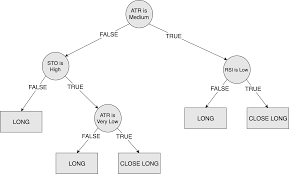


</figure>
<b>Fontes:</b>
   

<ol> 
 
    
 
  <a href="http://ceur-ws.org/Vol-1864/paper_13.pdf">
  <li> <b>Automatic Creation of Stock Trading Rules on the
Basis of Decision Trees</b> </li>
    
 

</ol>
    
  

<div>
    <div class="alert alert-block alert-info" style="margin-top: 5px">
        <h>6.1) Geração da Base de Dados</h>
</div> </div>


In [9]:
trades = pd.DataFrame(index=df.index)
trades['Close']=data['WEGE3.SA'].close.values
IFR(trades)


short=5
long=30

trades['short'] = trades['Close'].rolling(window=short).mean()
trades['long'] = trades['Close'].rolling(window=long).mean()
trades['cross']=trades['short']-trades['long']
# Sinal de Entrada
trades['signal']=0
trades['signal'] = np.where(trades['short'] > trades['long'], 1.0, 0.0)   


# Posição dos trades
trades['positions'] = trades['signal'].diff()

trades['Close_recorte']=trades['Close']*trades['signal']
trades=trades.dropna()
trades.head()

,Close,IFR,short,long,cross,signal,positions,Close_recorte
Date,,,,,,,,
2010-03-30,5.52,0.685045,5.418,5.325333,0.092667,1.0,1.0,5.52
2010-03-31,5.62,0.751388,5.474,5.335000,0.139000,1.0,0.0,5.62
2010-04-01,5.62,0.751388,5.518,5.341333,0.176667,1.0,0.0,5.62
2010-04-05,5.58,0.675601,5.566,5.350667,0.215333,1.0,0.0,5.58
2010-04-06,5.52,0.575191,5.572,5.355667,0.216333,1.0,0.0,5.52


In [10]:
pos_buy=np.where(trades['positions']==1)
pos_sell=trades['positions']==-1
days_buy=trades['Close'][trades['positions']==1].index
days_sell=trades['Close'][trades['positions']==-1].index
distance=days_sell-days_buy
buy_trade=[]
trades['class']=0
for i in range(len(days_buy)):
    values_2=trades['Close'][trades['Close'].index==(days_buy[i]+distance[i])].values[0]
    values_1=trades['Close'][trades['Close'].index==days_buy[i]].values[0]
    buy_trade.append((values_2-values_1)/values_1)
    if (values_2-values_1)/values_1>0:
        trades['class'][trades['Close'].index==days_buy[i]]=1
        trades['class'][trades['Close'].index==(days_buy[i]+distance[i])]=-1
        print(days_buy[i],distance[i])
trades['class']=trades['class'].cumsum()    
trades['class'][trades['class']==1]='buy'
trades['class'][trades['class']==0]='stop'
my_data=trades[['cross','IFR','class']]
X = my_data[['cross','IFR']].values
y = my_data['class'].values
print(X[0:15])
print(y[0:15])
from sklearn.model_selection import train_test_split
#X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.2)#, random_state=3)
X_trainset=X[:1808]
X_testset=X[1808:]
y_trainset=y[:1808]
y_testset=y[1808:]

print("shape X_trainset = ", X_trainset.shape)
print("shape y_trainset = ", y_trainset.shape)
print("shape X_testset = ", X_testset.shape)
print("shape y_testset = ", y_testset.shape)   

2010-07-26 00:00:00 28 days 00:00:00
2010-09-27 00:00:00 74 days 00:00:00
2011-03-21 00:00:00 29 days 00:00:00
2011-08-31 00:00:00 71 days 00:00:00
2011-12-21 00:00:00 57 days 00:00:00
2012-08-03 00:00:00 84 days 00:00:00
2012-10-29 00:00:00 77 days 00:00:00
2013-04-30 00:00:00 42 days 00:00:00
2013-10-08 00:00:00 83 days 00:00:00
2014-02-14 00:00:00 98 days 00:00:00
2014-09-01 00:00:00 39 days 00:00:00
2014-10-29 00:00:00 51 days 00:00:00
2014-12-23 00:00:00 65 days 00:00:00
2015-04-30 00:00:00 90 days 00:00:00
2016-04-19 00:00:00 41 days 00:00:00
2016-07-20 00:00:00 100 days 00:00:00
2017-01-03 00:00:00 77 days 00:00:00
2017-04-26 00:00:00 43 days 00:00:00
2017-07-12 00:00:00 79 days 00:00:00
2017-10-04 00:00:00 20 days 00:00:00
2017-11-21 00:00:00 70 days 00:00:00
2018-07-10 00:00:00 35 days 00:00:00
2019-01-04 00:00:00 41 days 00:00:00
2019-05-29 00:00:00 82 days 00:00:00
[[0.09266667 0.68504527]
 [0.139      0.75138848]
 [0.17666667 0.75138848]
 [0.21533333 0.67560148]
 [0.2163333

<div>
    <div class="alert alert-block alert-info" style="margin-top: 5px">
        <h>6.2) Criando, Treinando e Testando o Modelo de Árvore </h>
</div> </div>


In [11]:
from sklearn.tree import DecisionTreeClassifier
renkos = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
renkos # it shows the default parameters
renkos.fit(X_trainset,y_trainset)
predTree = renkos.predict(X_testset)
print (predTree [0:10])
print (y_testset [0:10])
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

['buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy']
['buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy']
DecisionTrees's Accuracy:  0.8761726078799249
DecisionTrees's Accuracy:  0.8761726078799249


<div>
    <div class="alert alert-block alert-info" style="margin-top: 5px">
        <h>6.3) Apresentando a Árvore de Decisão </h>
</div> </div>


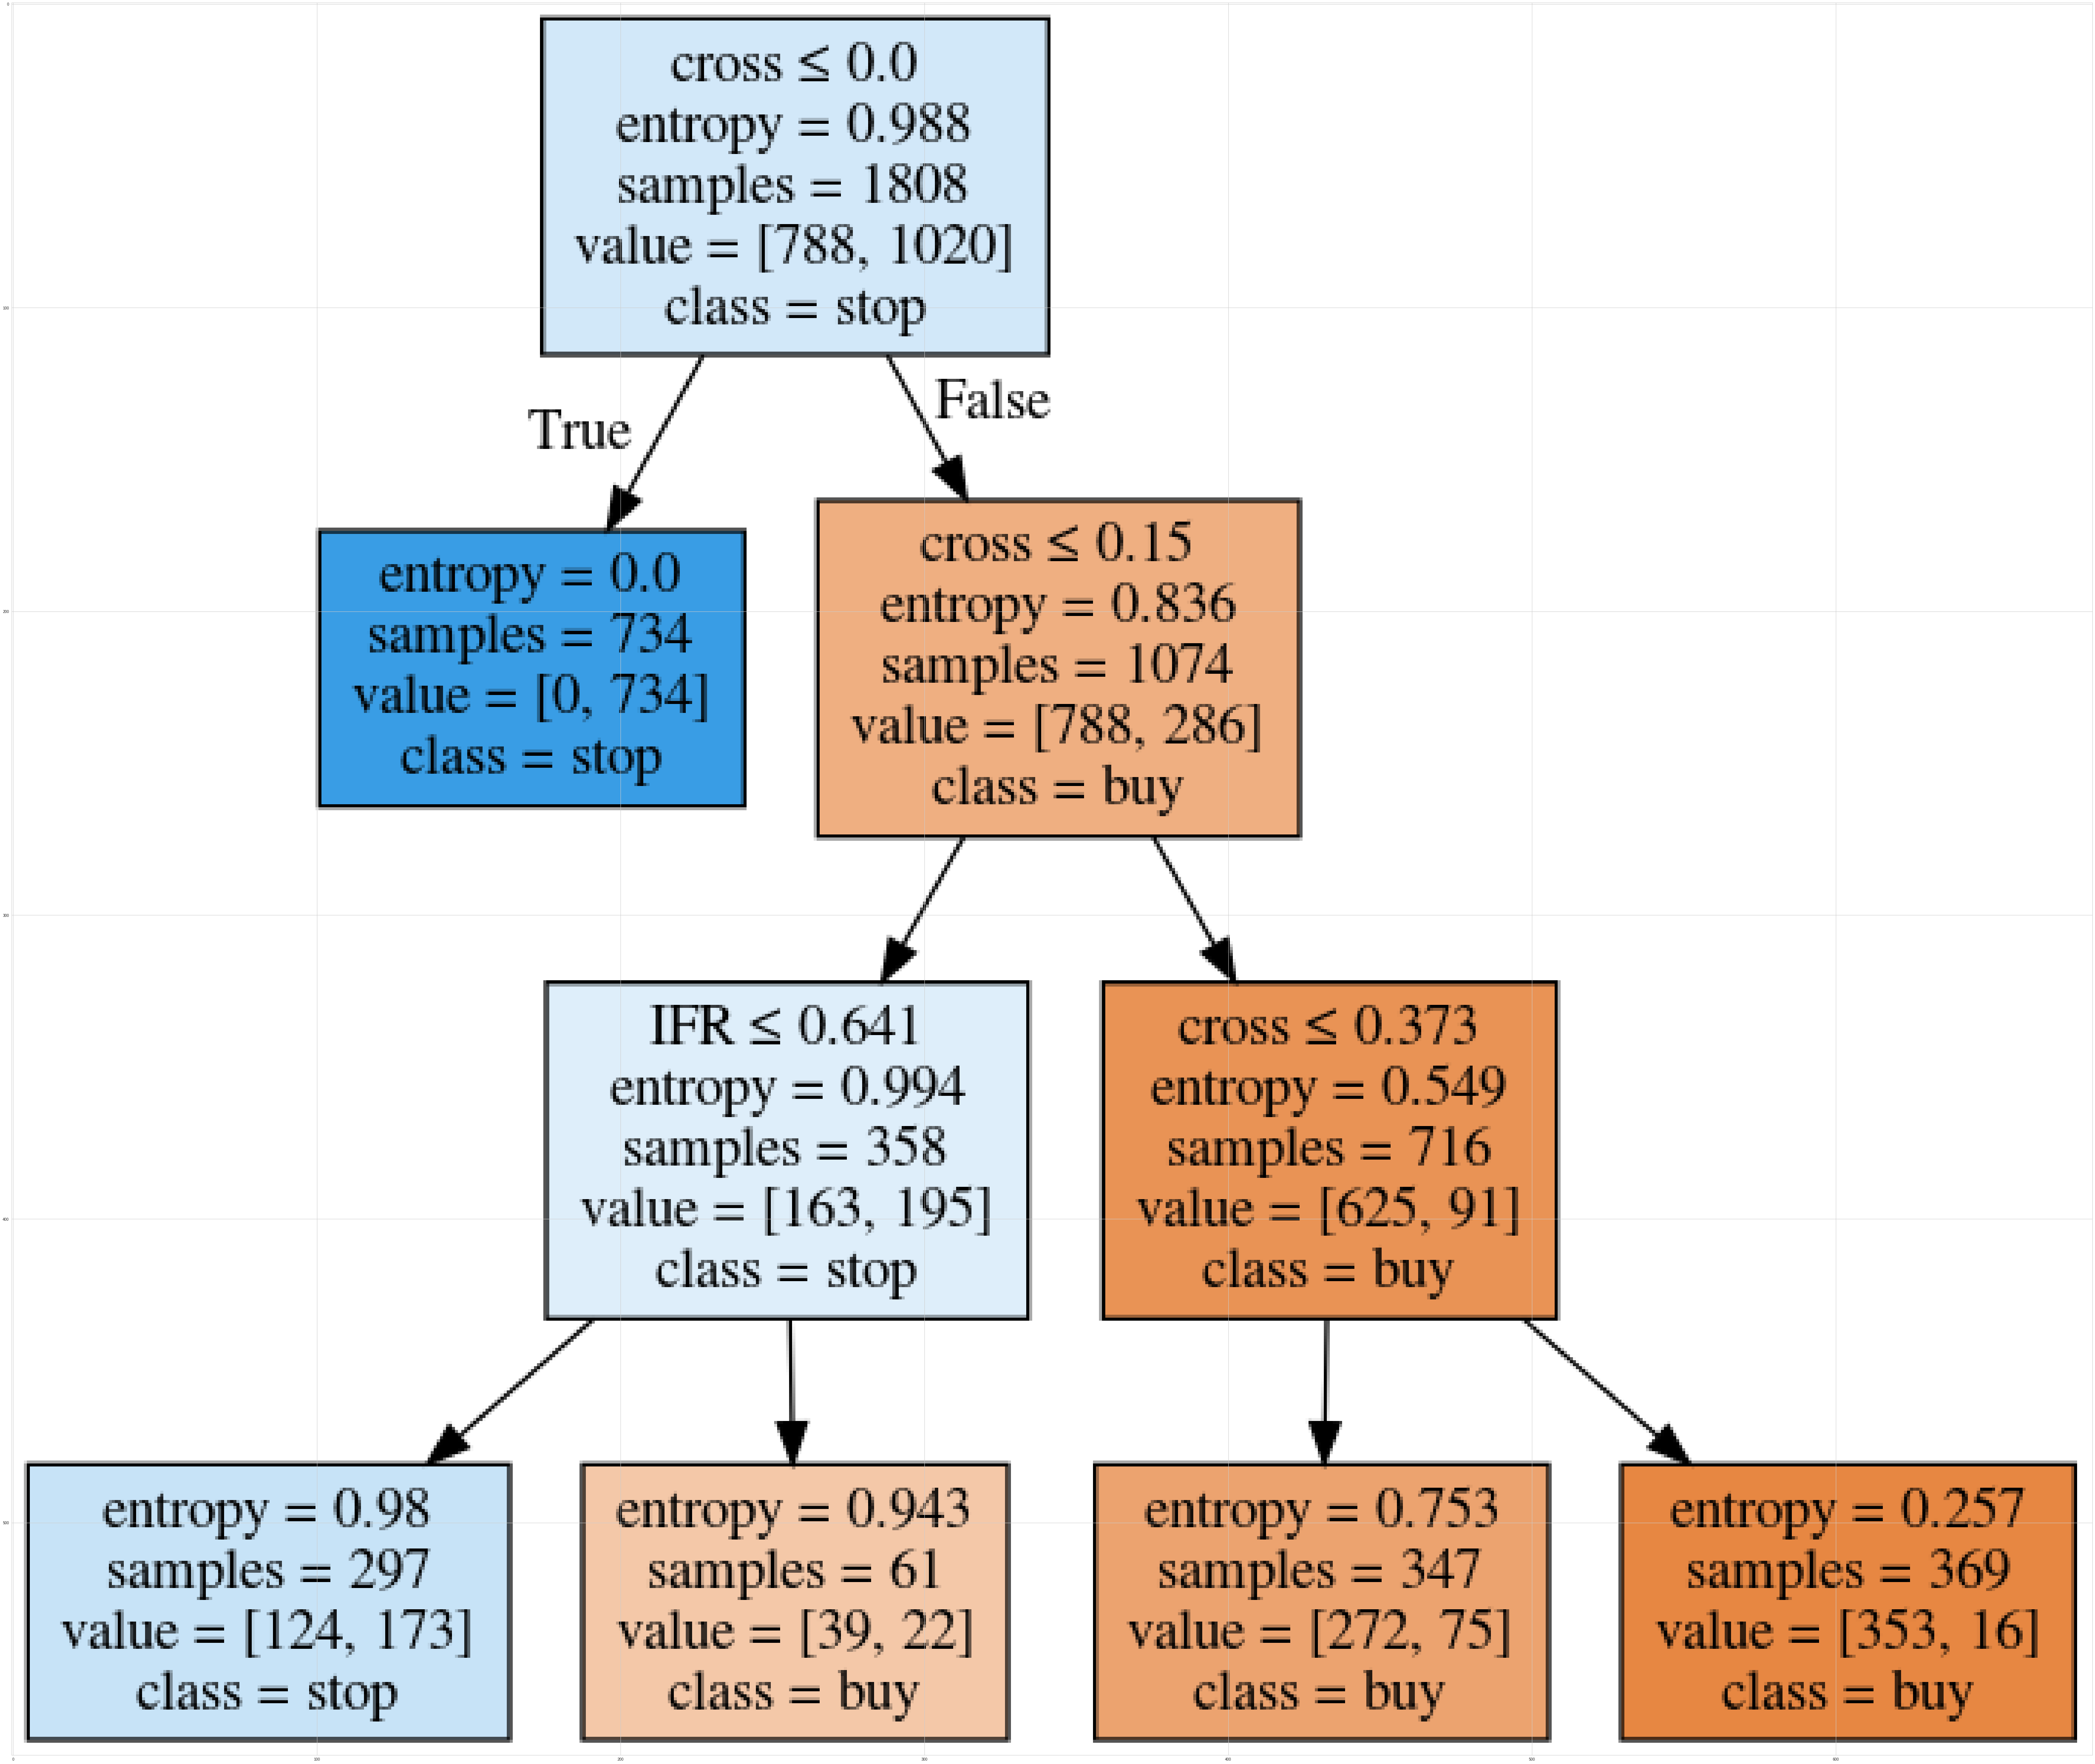

In [12]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 
dot_data = StringIO()
filename = "dt_cross.png"
featureNames = my_data.columns[0:2]
targetNames = my_data["class"].unique().tolist()
out=tree.export_graphviz(renkos,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

<div>
    <div class="alert alert-block alert-info" style="margin-top: 5px">
        <h>6.4) Avaliações Adicionais Relativas à Árvore Concebida </h>
</div> </div>

In [13]:
yhat = predTree
error=100*np.sum(yhat!=y_testset)/len(y_testset)
print("Incorrect Prediction = %.2f" % error, '%')

Incorrect Prediction = 12.38 %


             precision    recall  f1-score   support

        buy       0.78      0.97      0.87       220
       stop       0.98      0.81      0.88       313

avg / total       0.90      0.88      0.88       533

Confusion matrix, without normalization
[[214   6]
 [ 60 253]]


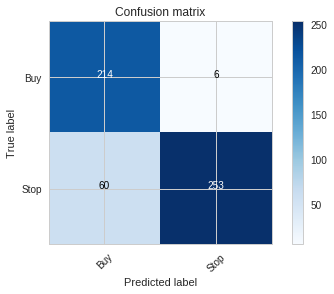

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

##https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Compute confusion matrix
cnf_matrix = confusion_matrix(list(y_testset), list(yhat))
np.set_printoptions(precision=2)
cnf_matrix
print (classification_report(list(y_testset), list(yhat)))

# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Buy','Stop'],normalize= False,  title='Confusion matrix')


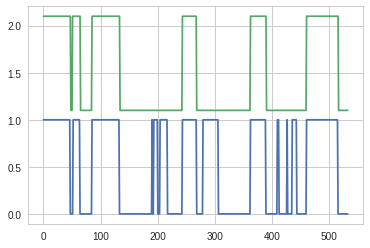

In [15]:
y_testset[np.where(y_testset=='buy')]=1
y_testset[np.where(y_testset=='stop')]=0
yhat[np.where(yhat=='buy')]=1
yhat[np.where(yhat=='stop')]=0
plt.plot(yhat)
plt.plot(y_testset+1.1)

<div id="Tópico 6">
    <div class="alert alert-block alert-info" style="margin-top: 0px">
        <h><a href="#Tópicos"><h2>7) Avaliação Seguidor de Tendência Crossover/Decision Tree</h2></a></h>   
</div> </div>

<p>A estratégia em Árvore de Decisão apresentado estabeleceu um conjunto de regras objetivas. A seguir será desenvolvido uma estratégia, somente comprada, considerado a função  $cross$ de cruzamento das médias (longa e curta) . A escolha em adotar somente a função $cross$ foi baseado no menor nível de entropia revelada pela árvore quando aplicado nessa função</p>


<p>o sinal de compra deve ocorrer quando</p>

  <li>$cross>0.373$</li>

<p>e o sinal de venda<p>

  <li>$cross<0.373$</li>


In [16]:
trades = pd.DataFrame(index=df.index)
trades['Close']=data['WEGE3.SA'].close.values
IFR(trades)


short=5
long=30

trades['short'] = trades['Close'].rolling(window=short).mean()
trades['long'] = trades['Close'].rolling(window=long).mean()
trades['cross']=trades['short']-trades['long']
trades=trades.dropna()

#trades=trades.set_index('Date')
# Sinal de Entrada
trades['signal']=0
signal=np.zeros(len(trades['signal']))
buy=0
for day in range(1,len(trades)):
    cond1_buy=trades['cross'].iloc[day] > 0.373
    cond1_sell=trades['cross'].iloc[day] < 0.373


    if cond1_buy:
        buy = 1
    if (buy == True) & cond1_sell :
        buy = 0
    signal[day]=buy
trades['signal']=signal

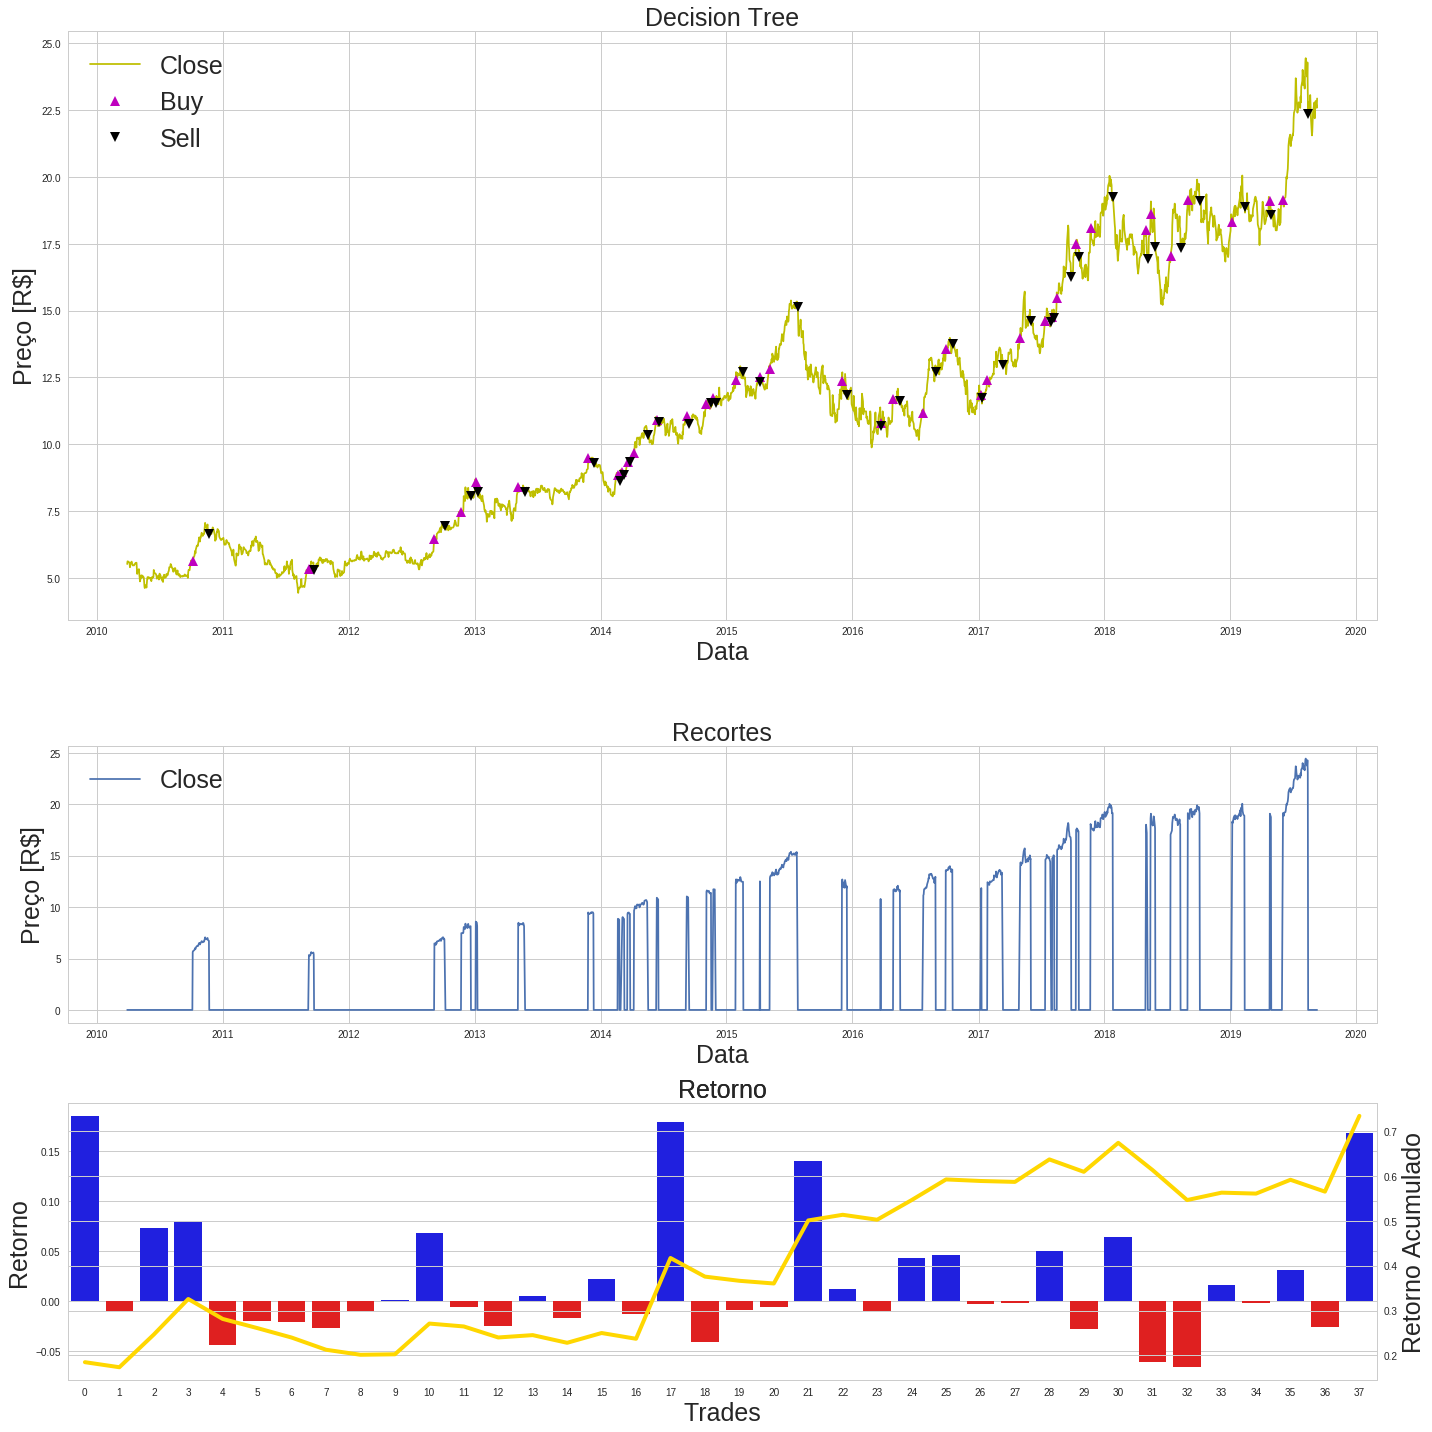

In [17]:
# Posição dos trades
trades['positions'] = trades['signal'].diff()

fig = plt.subplots(figsize=(20,20))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(211)
ax1.plot( trades.Close, 'y', label = 'Close')

ax1.plot(trades.loc[trades.positions == 1.0].index, 
         trades.Close[trades.positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax1.plot(trades.loc[trades.positions == -1.0].index, 
         trades.Close[trades.positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 

ax1.set_ylabel("Preço [R$]",fontsize=25)
ax1.set_xlabel("Data",fontsize=25)
ax1.set_title("Decision Tree",fontsize=25)
ax1.legend(loc='upper left',fontsize=25)



trades['Close_recorte']=trades['Close']*trades['signal']

#trades['Close_recorte'][trades['Close_recorte']==0]=16

ax3 = plt.subplot(413)
ax3.plot(trades['Close_recorte'], label='Close')
ax3.set_ylabel("Preço [R$]",fontsize=25)
ax3.set_xlabel("Data",fontsize=25)
ax3.set_title("Recortes",fontsize=25)
ax3.legend(loc='upper left',fontsize=25)



ax5 = plt.subplot(414)
pos_buy=np.where(trades['positions']==1)
pos_sell=trades['positions']==-1
days_buy=trades['Close'][trades['positions']==1].index
days_sell=trades['Close'][trades['positions']==-1].index
distance=days_sell-days_buy
buy_trade=[]
for i in range(len(days_buy)):
    values_2=trades['Close'][trades['Close'].index==(days_buy[i]+distance[i])].values[0]
    values_1=trades['Close'][trades['Close'].index==days_buy[i]].values[0]
    buy_trade.append((values_2-values_1)/values_1)
values = np.array(buy_trade)   
idx = np.array(list(range(len(buy_trade)))) 
clrs = ['red' if (x < 0) else 'blue' for x in values]
sns.barplot(x=idx, y=values, palette=clrs) 

plt.ylabel('Retorno',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Retorno',fontsize=25)
              
ax52 = ax5.twinx()
ax52.plot(sumper(values),'gold',linewidth=4)

values4=buy_trade
plt.ylabel('Retorno Acumulado',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Retorno',fontsize=25)

plt.tight_layout() 


<div id="Tópico 7">
    <div class="alert alert-block alert-info" style="margin-top: 0px">
        <h><a href="#Tópicos"><h2>8) Resultados Consolidados de Todas às Estratégias</h2></a></h>   
</div> </div>

<p>Na presente aula foram desenvolvidos 4 (quatro) estratégias básicas de trade automático. Assim, no sentido de estabelecer uma primeira comparação, entre os setups, medidas clássicas de perfomance serão determinadas, como: i) Quantidade de Operações, ii) Relação Retorno/Lucro, iii) Fator de Lucro, iv) Lucro e v) Taxa de Acerto. É notório que muitas outras medidas relevantes podem ser aplicadas (Exemplo: drawdown, fator de recuperação, payoff e etc) que serão, naturalmente, inseridos no decorrer das atividades futuras</p>

In [18]:
values=[values1,values2,values3,values4]
print()
print('Resultados Consolidados para as 4 Estratégias:')
print()
for i in range(len(values)):
    OP, LR, payoff, FL, Gains, Profit=result(values[i])
    print('Estratégia %.i, Operações: %.i, Lucro/Retorno: %.2f, Fator de Lucro: %.2f, Lucro: %.2f e Taxa de Acertos: %.2f ' 
          % (i+1,OP, LR,payoff,Profit,Gains ))
    print()


Resultados Consolidados para as 4 Estratégias:

Estratégia 1, Operações: 55, Lucro/Retorno: 0.26, Fator de Lucro: 1.93, Lucro: 106.24 e Taxa de Acertos: 43.64 

Estratégia 2, Operações: 49, Lucro/Retorno: 0.23, Fator de Lucro: 1.82, Lucro: 89.10 e Taxa de Acertos: 44.90 

Estratégia 3, Operações: 30, Lucro/Retorno: 1.04, Fator de Lucro: 3.34, Lucro: 100.07 e Taxa de Acertos: 83.33 

Estratégia 4, Operações: 38, Lucro/Retorno: 0.31, Fator de Lucro: 1.93, Lucro: 73.35 e Taxa de Acertos: 44.74 



<b>Fim da Atividade!!!</b> 
